In [82]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/kaggle/Feature_Engineering/Automobile_data.csv")

In [84]:
from sklearn.feature_selection import mutual_info_regression

def plot_variance(pca, width=8, dpi=100):
  fig, axs = plt.subplots(1, 2)
  n = pca.n_components_
  grid = np.arange(1, n+1)

  evr = pca.explained_variance_ratio_
  axs[0].bar(grid, evr)
  axs[0].set(xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0))
  cv = np.cumsum(evr)
  axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
  axs[1].set(xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0))

  fig.set(figwidth=8, dpi=100)
  return axs

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [86]:
df.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.4,10.0,102,5500,24,30,13950
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.4,8.0,115,5500,18,22,17450


In [87]:
df.replace("?", np.nan, inplace=True)
df.drop("normalized-losses", axis=1, inplace=True)

In [88]:
features = ["highway-mpg", "engine-size", "horsepower", "curb-weight"]

X = df.copy().dropna()
y = X.pop("price").astype("int")
X = X.loc[:, features]

X["horsepower"] = X["horsepower"].astype("int")
X_scaled = (X-X.mean(axis=0)) / X.std(axis=0)

In [89]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4
0,0.382486,-0.400222,0.124122,0.169539
1,0.382486,-0.400222,0.124122,0.169539
2,1.550890,-0.107175,0.598361,-0.256081
3,-0.408859,-0.425947,0.243335,0.013920
4,1.132749,-0.814565,-0.202885,0.224138


In [90]:
loadings = pd.DataFrame(
    pca.components_.T,  # transpose the matrix of loadings
    columns=component_names,  # so the columns are the principal components
    index=X.columns,  # and the rows are the original features
)
loadings

,PC1,PC2,PC3,PC4
highway-mpg,-0.492347,0.770892,0.070142,-0.397996
engine-size,0.503859,0.626709,0.019960,0.594107
horsepower,0.500448,0.013788,0.731093,-0.463534
curb-weight,0.503262,0.113008,-0.678369,-0.523232


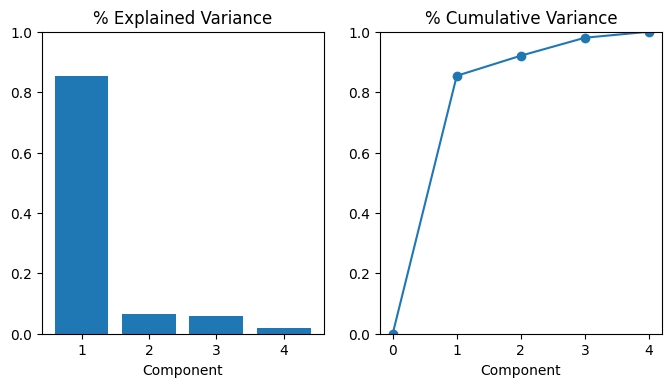

In [91]:
plot_variance(pca);

In [92]:
mi_scores = make_mi_scores(X_pca, y, discrete_features=False)
mi_scores

PC1    1.013912
PC2    0.379616
PC3    0.306602
PC4    0.204369
Name: MI Scores, dtype: float64

In [93]:
idx = X_pca["PC3"].sort_values(ascending=False).index
cols = ["make", "body-style", "horsepower", "curb-weight"]
df.loc[idx, cols]

,make,body-style,horsepower,curb-weight
118,plymouth,hatchback,68,1918
117,peugot,sedan,142,3130
119,plymouth,hatchback,102,2128
45,isuzu,sedan,70,1909
96,nissan,sedan,69,1971
...,...,...,...,...
59,mazda,hatchback,84,2385
61,mazda,hatchback,84,2385
101,nissan,sedan,152,3095
105,nissan,hatchback,200,3139


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   make               205 non-null    object 
 2   fuel-type          205 non-null    object 
 3   aspiration         205 non-null    object 
 4   num-of-doors       203 non-null    object 
 5   body-style         205 non-null    object 
 6   drive-wheels       205 non-null    object 
 7   engine-location    205 non-null    object 
 8   wheel-base         205 non-null    float64
 9   length             205 non-null    float64
 10  width              205 non-null    float64
 11  height             205 non-null    float64
 12  curb-weight        205 non-null    int64  
 13  engine-type        205 non-null    object 
 14  num-of-cylinders   205 non-null    object 
 15  engine-size        205 non-null    int64  
 16  fuel-system        205 non

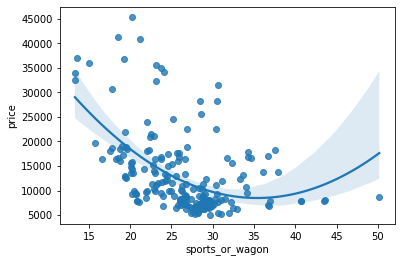

In [97]:
df["sports_or_wagon"] = X["curb-weight"] / X["horsepower"]
df.dropna(inplace=True)
df["price"] = df["price"].astype("int")
sns.regplot(x="sports_or_wagon", y='price', data=df, order=2);